# Final

Загрузка данных:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

data = pd.read_csv('features.csv').iloc[:, 1:]
data_test = pd.read_csv('features_test.csv').iloc[:, 1:]
X = data.iloc[:, :len(data_test.columns)]
X_test= data_test
y = data['radiant_win'].fillna(0)
print('Features:', X.columns)
print('Test Features:', X_test.columns)

Features: Index(['start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold',
       'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items',
       ...
       'radiant_ward_sentry_count', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_tpscroll_count', 'dire_boots_count', 'dire_ward_observer_count',
       'dire_ward_sentry_count', 'dire_first_ward_time'],
      dtype='object', length=102)
Test Features: Index(['start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold',
       'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items',
       ...
       'radiant_ward_sentry_count', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_tpscroll_count', 'dire_boots_count', 'dire_ward_observer_count',
       'dire_ward_sentry_count', 'dire_first_ward_time'],
      dtype='object', length=102)


Общая функция обучения, возвращает обученный классификатор, средний cv score и время обучения

In [2]:
# Learning function for any classifier, returns learned classifier, mean cv score and learning time
def learning(X, y, clf, cv):
    all_score_cv = []
    start_time = datetime.now()
    for train_idx, test_idx in cv.split(X):
        X_train_cv = X[train_idx,:]
        y_train_cv = y[train_idx]
        clf.fit(X_train_cv, y_train_cv)
        y_pred = clf.predict_proba(X[test_idx])[:,1]
        score_cv = roc_auc_score(y[test_idx], y_pred)
        all_score_cv += [score_cv]
        time_spent = (datetime.now() - start_time).total_seconds()
    return clf, np.mean(all_score_cv), time_spent

## Подход 1 Градиентный бустинг

### 1. Какие признаки имеют пропуски среди своих значений (приведите полный список имен этих признаков)? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

In [7]:
len_x = len(X)
for l in X.columns:
    curr_len_x = X[l].count()
    if len_x != curr_len_x:
        print(curr_len_x, 'in', len_x, l)
X = X.fillna(0)
X_test = X_test.fillna(0)
print('first_blood_time First blood может не быть за первые 5 мин, radiant_courier_time курьера могут купить после 5 минуты.')

first_blood_time First blood может не быть за первые 5 мин, radiant_courier_time курьера могут купить после 5 минуты.


### 2. Как называется столбец, содержащий целевую переменную?

In [4]:
'radiant_win'

'radiant_win'

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти выше по тексту. Какое качество при этом получилось?

Number of trees: 28
GradientBoosting score: 0.6884415067825458
Time spent: 149.883592 sec
Number of trees: 30
GradientBoosting score: 0.6889127161437701
Time spent: 145.710761 sec
Number of trees: 32
GradientBoosting score: 0.6904406148075195
Time spent: 156.133689 sec
Number of trees: 34
GradientBoosting score: 0.6916441862557775
Time spent: 159.56274 sec
Number of trees: 36
GradientBoosting score: 0.6925509897312214
Time spent: 192.434587 sec


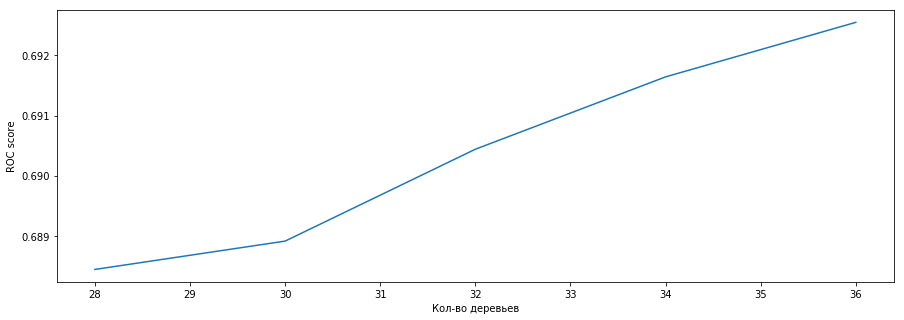

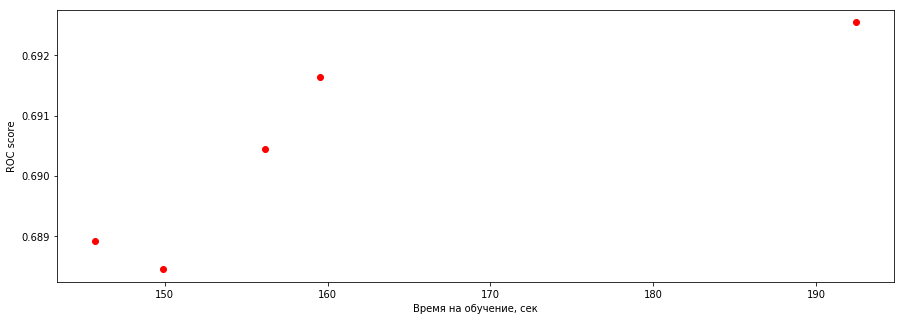

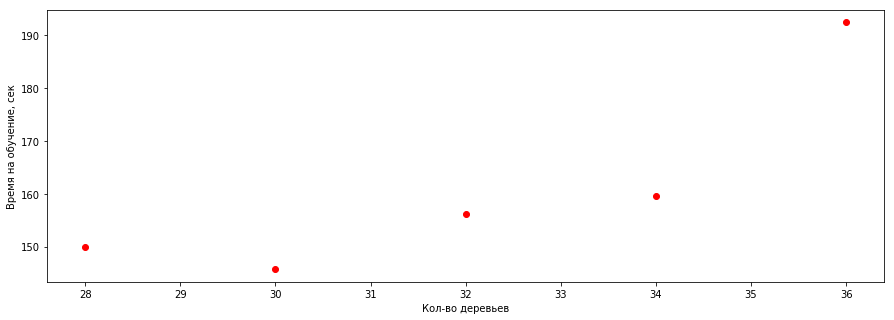

Время для 30 деревьев: 145.710761 sec


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from datetime import datetime

cv = KFold(n_splits=5, shuffle=True)
n_trees_all = [28,30,32,34,36]
all_gb_score = []
all_gb_spent_time = []
for n_trees in n_trees_all:
    clf = GradientBoostingClassifier(n_estimators=n_trees, learning_rate=0.1)
    print('Number of trees:', n_trees)
    clf, gb_score, time_spent = learning(X.values, y.values, clf, cv)
    all_gb_score += [gb_score]
    print('GradientBoosting score:', gb_score)
    all_gb_spent_time += [time_spent]
    print('Time spent:', time_spent, 'sec')
plt.figure(figsize = (15, 5))
plt.plot(n_trees_all, all_gb_score)
plt.xlabel('Кол-во деревьев')
plt.ylabel('ROC score')
plt.show()
plt.figure(figsize = (15, 5))
plt.plot(all_gb_spent_time, all_gb_score, 'ro')
plt.xlabel('Время на обучение, сек')
plt.ylabel('ROC score')
plt.show()
plt.figure(figsize = (15, 5))
plt.plot(n_trees_all, all_gb_spent_time, 'ro')
plt.xlabel('Кол-во деревьев')
plt.ylabel('Время на обучение, сек')
plt.show()
print('Время для 30 деревьев:', all_gb_spent_time[1], 'sec')

### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что можно сделать, чтобы ускорить его обучение при увеличении количества деревьев?

In [8]:
print('Да, но небольшой, возможно переобучение. Лучше увеличить количество разбиений KFold.')
print('Обучаться на подвыборках признаков и ограничить глубину деревьев.')

Да, но небольшой, возможно переобучение. Лучше увеличить количество разбиений KFold.
Обучаться на подвыборках признаков и ограничить глубину деревьев.


## Подход 2 Логистическая регрессия

In [1]:
for C in [0.1]:
    print (C)

0.1


C:\Users\shishkinpi\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shishkinpi\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Score cv: 0.7164354409453184
Time spent: 19.637489


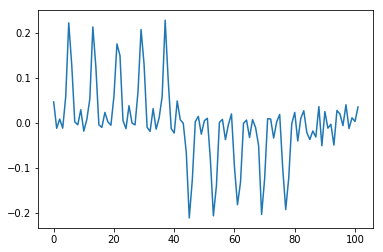

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from datetime import datetime

scaler = StandardScaler()
X_lr1 = scaler.fit_transform(X)
for C in [0.1]:
    clf_lr1 = LogisticRegression(penalty='l2', C=C, solver="sag")
    cv = KFold(n_splits=5, shuffle=True)
    #score_lr1 = np.mean(cross_val_score(clf_lr1, X_lr1, y, cv=cv, scoring="roc_auc"))
    clf_lr1, score_lr1, time_spent_lr1 = learning(X_lr1, y.values, clf_lr1, cv)
    print('Score cv:', score_lr1)
    print('Time spent:', time_spent_lr1)
    plt.plot(clf_lr1.coef_[0])
    plt.show()

### 1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем можно объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [11]:
print('Качество:', score_lr1)
print('Лучше, чем бустинг')
print('Бустинг строит много слабых деревьев и каждым следующим пытается исправить ошибки предыдущих, а логистическая регрессия строит один алгоритм, но лучшего качества.')
print('Намного быстрее, в нашем случае на', all_gb_spent_time[1]-time_spent_lr1, 'сек')

Качество: 0.7164354409453184
Лучше, чем бустинг
Бустинг строит много слабых деревьев и каждым следующим пытается исправить ошибки предыдущих, а логистическая регрессия строит один алгоритм, но лучшего качества.
Намного быстрее, в нашем случае на 126.07327199999999 сек


### 2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем можно объяснить это изменение?

C:\Users\shishkinpi\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shishkinpi\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Score cv: 0.7165596027502772
Time spent: 19.476395


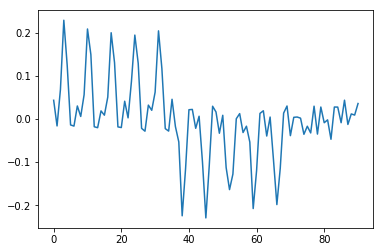

Возможно влияет, но незначительно. Наш алгоритм настраивается так, чтобы не замечать эти признаки, когда они присутствуют, поэтому разницы не видно.


In [12]:
rem_col = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
X_lr2 = X.drop(rem_col, axis=1)
scaler = StandardScaler()
X_lr2 = scaler.fit_transform(X_lr2)
for C in [1.]:
    clf_lr2 = LogisticRegression(penalty='l2', C=C, solver="sag")
    cv = KFold(n_splits=5, shuffle=True)
    #score_lr2 = np.mean(cross_val_score(clf_lr2, X_lr2, y, cv=cv, scoring="roc_auc"))
    clf_lr2, score_lr2, time_spent_lr2 = learning(X_lr2, y.values, clf_lr2, cv)
    print('Score cv:', score_lr2)
    print('Time spent:', time_spent_lr2)
    plt.plot(clf_lr2.coef_[0])
    plt.show()
print('Возможно влияет, но незначительно. Наш алгоритм настраивается так, чтобы не замечать эти признаки, когда они присутствуют, поэтому разницы не видно.')

### 3. Сколько различных идентификаторов героев существует в данной игре?

In [14]:
heroes_values = X[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']]
all_used_heroes = []
for colidx in range(len(heroes_values.columns)):
    all_used_heroes.extend(list(pd.unique(heroes_values.iloc[:,colidx])))
all_used_heroes = pd.unique(all_used_heroes)
print('Героев в выборке:', len(all_used_heroes))

Героев в выборке: 108


Подготовка мешка слов:

In [15]:
heroes_values_r = X[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']]
heroes_values_d = X[['d1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']]
rem_col = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
X_lr3 = X.drop(rem_col, axis=1)
X_lr3_lobby = X['lobby_type'].astype(int)
X_lr3_h_l = pd.DataFrame()
X_lr3_r = pd.DataFrame()
X_lr3_d = pd.DataFrame()
X_lr3_lb = pd.DataFrame()
for hero in all_used_heroes:
    this_hero = np.zeros(heroes_values_r.shape[0])
    for h in (heroes_values_r.values == hero).T:
        this_hero += h
    X_lr3_r[hero] = this_hero.astype(int)
for hero in all_used_heroes:
    this_hero = np.zeros(heroes_values_d.shape[0])
    for h in (heroes_values_d.values == hero).T:
        this_hero -= h
    X_lr3_d[hero] = this_hero.astype(int)
for lb in [7, 0, 1]:
    X_lr3_lb['lb'+str(lb)] = (X_lr3_lobby == lb).astype(int)
X_lr3_h_l = X_lr3_r + X_lr3_d
X_lr3_h_l = np.hstack((X_lr3_h_l, X_lr3_lb))
X_lr3_h_l = np.hstack((X_lr3.values, X_lr3_h_l))

### 4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем можно это объяснить?

C = 1.6
Score cv: 0.7519792777591521
Time spent: 38.75413


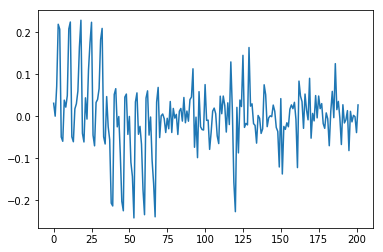

In [16]:
scaler = StandardScaler()
X_lr3_h_l = scaler.fit_transform(X_lr3_h_l)
for C in [1.6]:
    print("C =", C)
    clf_lr3 = LogisticRegression(penalty='l2', C=C, solver="sag")
    cv = KFold(n_splits=5, shuffle=True)
    #score_lr3 = np.mean(cross_val_score(clf_lr3, X_lr3_h_l, y, cv=cv, scoring="roc_auc"))
    clf_lr3, score_lr3, time_spent_lr3 = learning(X_lr3_h_l, y.values, clf_lr3, cv)
    print('Score cv:', score_lr3)
    print('Time spent:', time_spent_lr3)
    plt.plot(clf_lr3.coef_[0])
    plt.show()

### 5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [17]:
heroes_values = X_test[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']]
all_used_heroes = []
for colidx in range(len(heroes_values.columns)):
    all_used_heroes.extend(list(pd.unique(heroes_values.iloc[:,colidx])))
all_used_heroes = pd.unique(all_used_heroes)
heroes_values_r = X_test[['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']]
heroes_values_d = X_test[['d1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']]
rem_col = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
X_t = X_test.drop(rem_col, axis=1)
X_t_r = pd.DataFrame()
X_t_d = pd.DataFrame()
for hero in all_used_heroes:
    this_hero = np.zeros(heroes_values_r.shape[0])
    for h in (heroes_values_r.values == hero).T:
        this_hero += h
    X_t_r[hero] = this_hero.astype(int)
    this_hero = np.zeros(heroes_values_d.shape[0])
    for h in (heroes_values_d.values == hero).T:
        this_hero -= h
    X_t_d[hero] = this_hero.astype(int)
X_t_h = X_t_r + X_t_d
for lb in [7, 0, 1]:
    X_t_h['lb'+str(lb)] = (X_lr3_lobby == lb).astype(int)
X_t = np.hstack((X_t, X_t_h))
X_t = scaler.transform(X_t)
predictions_for_test = clf_lr3.predict_proba(X_t)[:,1]

In [18]:
print('Максимальное значение:', max(predictions_for_test))
print('Минимальное значение:', min(predictions_for_test))

Максимальное значение: 0.9968877117882979
Минимальное значение: 0.0035238878428415416
